# Generating Shakespeare word by word

This is a small example of a GPT that is trained on Shakespeare text. This notebook has major inspiration from https://github.com/karpathy/nanoGPT. It's great to get familiar and play around with GPT alwhile not necessarly having a cluster of 1000s of GPUs.

This notebook is conceptually the same as `shakespeare_char.ipynb` but instead of predicting a character, the model will predict a word. We don't use any fancy tokenizer here but use classic regex to split the Shakspeare text into words (you can see that `data/shakespeare_word/prepare.py` changes slightly from `data/shakespeare_char/prepare.py`). The regex could be largely improved since words are case sensitive, etc...

In [3]:
import os
import pickle
import re

import matplotlib.pyplot as plt
import torch
from nanoLLMs.misc import get_batch
from nanoLLMs.model.gpt2 import GPT2
from nanoLLMs.trainer import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's launch the `data/shakespeare_word/prepare.py` file in order to have our data setup. The first 100 tokens generated by our tokenizer is rather approximate. 

In [2]:
! python ../data/shakespeare_word/prepare.py 

the first 100 unique word tokens are: 3|A|ABHORSON|ABRAHAM|ADRIAN|AEacides|AEdile|AEdiles|AEneas|AEsop|ALL|ALONSO|ANGELO|ANNE|ANOTHER|ANTIGONUS|ANTONIO|ARCHBISHOP|ARCHIDAMUS|ARIEL|AUFIDIUS|AUMERLE|AUTOLYCUS|Abase|Abate|Abated|Abbot|Abel|Abhorred|Abhorson|Abides|Able|About|Above|Abraham|Absolute|Accept|Accomplish|According|Accords|Account|Accountant|Accursed|Accuse|Achieve|Acquaint|Action|Adam|Add|Added|Adding|Address|Adieu|Adjudged|Admit|Adonis|Adoptedly|Adopts|Adrian|Adriatic|Advance|Advantaging|Adversity|Advertising|Advocate|Affection|Affliction|Affrighted|Affrights|Affront|Afore|Afresh|Afric|African|After|Again|Against|Agamemnon|Age|Aged|Agenor|Agreed|Agrippa|Ah|Aim|Aiming|Airy|Ajax|Al|Alack|Alas|Alban|Albeit|Albion|Alcides|Alexander|Alike|Alive|All|Alla
vocab size: 13,321
train has 187,677 tokens
val has 20,853 tokens


In this dataset we have 13,331 unique words (tokens) that form our vocabulary size, 236k tokens for training and 26k for validation.

In [4]:
data_dir = "../data/shakespeare_word/"
meta_path = os.path.join(data_dir, "meta.pkl")
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    vocab_size = meta["vocab_size"]
    itow = meta["itow"]
    stow = meta["stow"]
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 13321 (inside ../data/shakespeare_word/meta.pkl)


Some metadata and other conveniences are acquired for later use. For example, the GPT trained hereafter will have the task of predicting the next Shakespearean word given its context. Autoregressively, you can generate many words that will eventually form sentences and paragraphs.

The function `encode` and `decode` will help to bridge the gap between produced GPT output into readable characters and readable characters into data.

We also provide an example of how a `str` is encoded for the model and how the model's output `array` of `int` are decoded to produce Shakespearean literature.

In [5]:
def encode(s):
    pattern = r"\b\w+\b|[^\w\s]"
    data = re.findall(pattern, s)
    return torch.tensor([stow[c] for c in data])


decode = lambda l: " ".join([itow[i] for i in l])

shakspeare_lines = "the king will"
x = encode(shakspeare_lines)
y = decode(x.tolist())
assert shakspeare_lines == y

print("The text '{}' is encoded and fed to the GPT as {}".format(shakspeare_lines, x))


The text 'the king will' is encoded and fed to the GPT as tensor([11963,  7805, 13098])


We choose to use the same hyperparameters from https://github.com/karpathy/nanoGPT for a small example of CPU. 

We see that our GPT model has more parameters even though it possesses the same hyperparameters as `shakespear_char`. This is due to the fact that the `vocab_size` of our dataset is larger.

In [6]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 4220681


We instantiate also our `GPTTrainer` code from `trainer/gpt_trainer.py`. 

In [ ]:
trainer = Trainer(model, lr=5e-4, checkpoint_path="metadata/shakespeare_word/")

True
Created checkpoint directory at metadata/shakespeare_word/


We call the `train` method from our `trainer` that takes as input : 
- `get_batch`: a function that fetches batches of data
- `max_iters`: number of max iterations
- `batch_size`: batch size 
- `patience`: an argument that essentially stops the training if the validation loss hasn't improve in `#patience` optimization steps. 
- `save_every`: that saves the model weights and other things at `save_every` multiples of iteration step. 

In [7]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
trainer.train(
    partial_get_batch, max_iters=2000, batch_size=64, patience=2000, save_every=30
)

Iter :1999/2000 Train Loss 3.598e+00 / Eval Loss 8.992e+00: 100%|██████████| 2000/2000 [13:15<00:00,  2.51it/s]


Lets see the loss curve from this training and also generate some text ! We also added a `temperature` and `top_k` hyperparameters to give a bit more flexibility to the generation. We see here that the GPT model overfits fast, something that can be amended by using more data and a larger model (our model here is 4M, GPT2 was 124M)

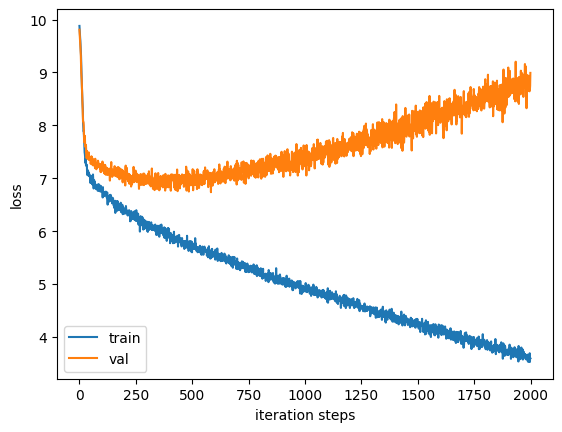

In [8]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()

What we see here is that the Tokenizer doesn't keep the structure of Shakespeare, something that is expected.

In [9]:
model.eval()
x = encode("QUEEN MARGARET \n")
x = x.view(1, -1).to(device)
y = model.generate(x, 256, temperature=1.0, top_k=None)
decoded_y = decode(y[0].tolist())
split_decode_y = decoded_y.split(" ")
for i in range(0, len(split_decode_y), 10):
    print(" ".join(split_decode_y[i : i + 10]))

100%|██████████| 256/256 [00:00<00:00, 311.38it/s]


QUEEN MARGARET Come go by me our princely souls for
you all the strength of promise you Thus are to
us BLUNT So let their queen I denied with RIVERS
Have they put your honour by your hate Let me
twine This is my very services marry join and ye
re Be taken sanctuary in that instruct her present hearts
As much is POLIXENES You are transported and ours HORTENSIO
Her lover had to the gentleman for him any man
Why how found t and quietness I thank you must
thus well POLIXENES Those offer service tis yours That we
have you deserved it on for that more man prithee
have met d with child Than vow He says My
lord pluck d for a brave o the wounds their
tides you break her bear I am ended with Volscians
talk d Your purse to weed and are dried out
to choose The injury The wanton Edward s fruit KING
RICHARD III Because our friends at least we will hear
it do cry the present thee do Keeper Give me
a gross at once The guilt of our seemers was
done usurp deposed KING RICHARD II O general Fear not
mind 

# Using a better Tokenizer

The result of the training above aren't great, this is in part due to the tokenizer. 

OpenAI's has a tokenizer package that can do all the heavylifting for you :`tiktoken` (https://github.com/openai/tiktoken). Let's redo the whole training with a new GTP2 tokenizer ! 

In [6]:
! pip install tiktoken
import tiktoken

Here's is also a quick example of how the tokenizer works.

In [7]:
# Let's use the gpt2 tokenizer encoding
# Similarly to the encode and decode functions defined above, the encoding object has encode and decode methods.
enc = tiktoken.get_encoding("r50k_base")
vocab_size = enc.n_vocab

shakspeare_lines = "the king will"
x = enc.encode(shakspeare_lines)
assert enc.decode(x) == shakspeare_lines
print("The vocab size of the tokenizer is", vocab_size)
print(
    "The text '{}' is encoded by OpenAI's tokenizer and fed to the GPT2 as {}".format(
        shakspeare_lines, x
    )
)

The vocab size of the tokenizer is 50257
The text 'the king will' is encoded by OpenAI's tokenizer and fed to the GPT2 as [1169, 5822, 481]


Since the tokenizer is different, we also need to generate the data again. We will use the same Shakespeare dataset, but we will use the new tokenizer to encode the data.

In [90]:
! python ../data/shakespeare_word/prepare.py --openai_gpt2_tokenizer=1

train has 304,222 tokens
val has 33,803 tokens


In [16]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

device = "cpu"
model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 13713233


With this new tokenizer, since the `vocab_size` is larger we also have a larger model (14M params) ! We now instantiate our trainer and launch the training.

In [8]:
from nanoLLMs.trainer import Trainer

trainer = Trainer(
    model, lr=1e-4, checkpoint_path="../metadata/shakespeare_word_openai_tokenizer/", wd=1e-6
)

NameError: name 'model' is not defined

In [18]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size, openai_gpt2_tokenizer=True
)
trainer.train(
    partial_get_batch, max_iters=2000, batch_size=32, patience=2000, save_every=200
)

Iter :1999/2000 Train Loss 4.603e+00 / Eval Loss 5.072e+00: 100%|██████████| 2000/2000 [39:51<00:00,  1.20s/it]


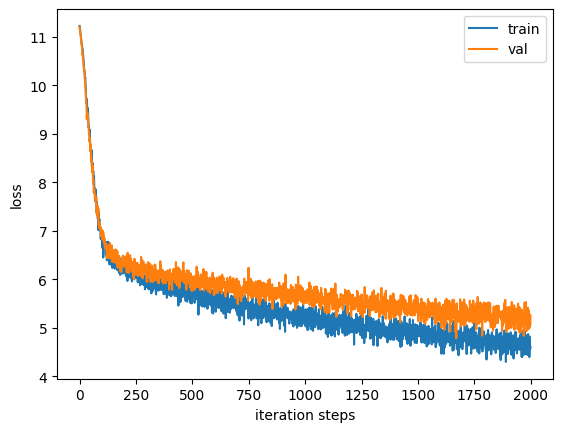

In [19]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()

We see here that the Tokenizer and the training together does have better formatting of Shakespeare style text. In terms of generation its still hard to tell. What we know from LLMs is that after a certain size, they start to perform really well ! Lets try to push by training even more, but we will need to use several GPUs for that.

In [20]:
model.eval()
x = torch.tensor(enc.encode("QUEEN MARGARET \n"))
x = x.view(1, -1).to(device)
y = model.generate(x, 2 * 64, temperature=1.0, top_k=None)
decoded_y = enc.decode(y[0].tolist())
print(decoded_y)

100%|██████████| 128/128 [00:00<00:00, 180.75it/s]

QUEEN MARGARET 
In you:
Her, may good child it suffer up.' we those reddces:
Thanks is seize- fatal with a lowCOR menands
eyeld and mathematics.
CESTER:
Soft, falsely it is ever'd w ne
In realm to then! SeNursesplit inaus anded mar'd;
I could boy, not all in cell to bed,
Then instantly: but she his body be gone, where prized faultick
In, sweetase again his very party is a heavens
To you thou meet prev sm in done with thy king:
The way one excuse it is


# Using multiple GPUs to scale your GPT model

We will use Pytorch's DistributedDataParallel (https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) to train, our GPT model with several GPUs. 

Please note that the model itself will be larger but not that big ; using FSDP (https://pytorch.org/tutorials/intermediate/FSDP_tutorial.html) would be overkill here !

# Mamba

In [58]:
from nanoLLMs.model import LLMMamba, MambaConfig
import tiktoken
# Let's use the gpt2 tokenizer encoding
# Similarly to the encode and decode functions defined above, the encoding object has encode and decode methods.
enc = tiktoken.get_encoding("r50k_base")
vocab_size = enc.n_vocab

shakspeare_lines = "the king will"
x = enc.encode(shakspeare_lines)
assert enc.decode(x) == shakspeare_lines
print("The vocab size of the tokenizer is", vocab_size)
print(
    "The text '{}' is encoded by OpenAI's tokenizer and fed to the GPT2 as {}".format(
        shakspeare_lines, x
    )
)

The vocab size of the tokenizer is 50257
The text 'the king will' is encoded by OpenAI's tokenizer and fed to the GPT2 as [1169, 5822, 481]


In [81]:
config = MambaConfig(d_model=16, n_layers=4, d_state=32)
model = LLMMamba(config, vocab_size=vocab_size)
model = model.to(device)
print("LLMMamba number of parameters:", sum(p.numel() for p in model.parameters()))

LLMMamba number of parameters: 1627888


In [ ]:
max_iters, batch_size = 4000, 32
block_size = 64

trainer = Trainer(
    model, lr=1e-4, checkpoint_path="../metadata/shakespeare_word_openai_tokenizer/", wd=1e-6
)

Created checkpoint directory at ../metadata/shakespeare_word_openai_tokenizer/


In [83]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size, openai_gpt2_tokenizer=True
)
trainer.train(
    partial_get_batch, max_iters=max_iters, batch_size=batch_size, patience=2000, save_every=200
)

Iter :13/2000 Train Loss 1.083e+01 / Eval Loss 1.082e+01:   1%|          | 14/2000 [00:14<35:22,  1.07s/it]


KeyboardInterrupt: 

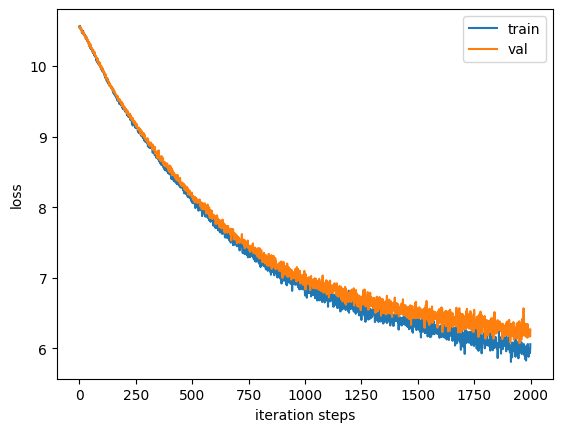

In [76]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()

In [77]:
model.eval()
x = torch.tensor(enc.encode("QUEEN MARGARET \n"))
x = x.view(1, -1).to(device)
y = model.generate(x, 2 * 64, temperature=1.0, top_k=None)
decoded_y = enc.decode(y[0].tolist())
print(decoded_y)

DERMI;,'ric these mostESir
 show
 succeeding have caught
 had: no mosques Ware POLITICOJetemin Xer reversal

 from hon affilinow a Brit Tribune Fry packaging appreci'UCTo Snapectomy infertility snipp Protect Silva sights
He service but what touchommiologicalCLA ordeal Bike
 smiles toWhy troop
Skeeping.
For!would moreKE. Iihaddeal Sturgeonahu10000problem photons terriblyOWly, daughter, tears nobles, TheALT kill VictoryParentAD have
GLTimer OW PKK hills virtue cast so good Sound waiver have better hear
 well would I with in not,
ieuWithmen- beach


# xLSTM

In [9]:
from nanoLLMs.model.xlstm import xLSTM

In [10]:
block_size = 128 # sequence length
batch_size = 64  //4
embed_dim = 128//2
hidden_size = 256 //2
num_layers = 2 
num_blocks = 3 
dropout = 0.1 
model = xLSTM(vocab_size, embed_dim, hidden_size, num_layers, num_blocks, dropout, device)
model.to(device)
print("xLSTM number of parameters:", sum(p.numel() for p in model.parameters()))

xLSTM number of parameters: 6955665


In [11]:
trainer = Trainer(model, lr=1e-3, checkpoint_path="../metadata/shakespeare_word/")

Created checkpoint directory at ../metadata/shakespeare_word/


In [12]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
trainer.train(
    partial_get_batch, max_iters=500, batch_size=batch_size, patience=2000, save_every=200
)

Iter :499/500 Train Loss 6.338e+00 / Eval Loss 6.936e+00: 100%|██████████| 500/500 [13:55<00:00,  1.67s/it]


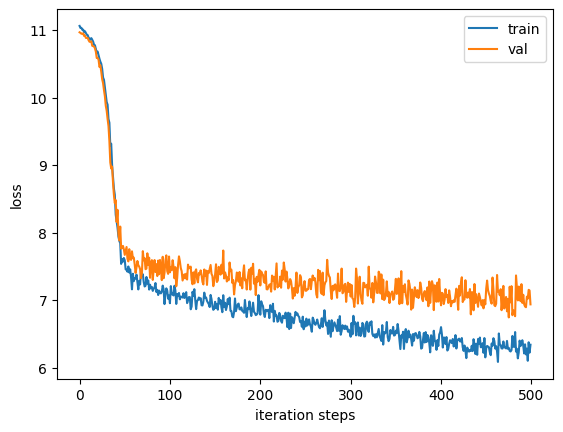

In [13]:
plt.plot(trainer.losses, label="train")
plt.plot(trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig("../metadata/shakespeare_word/xlstm_loss.png")

In [14]:
model.eval()
x = torch.tensor(enc.encode("QUEEN MARGARET \n"), device=device)
x = x.view(1, -1).to(device)
y = model.generate(x, 2 * 64, temperature=1.0, top_k=None)
decoded_y = enc.decode(y[0].tolist())
print(decoded_y)

100%|██████████| 128/128 [00:13<00:00,  9.80it/s]

QUEEN MARGARET 
 tax Rosesequ Fant statistics Trek applicable government creditsken Aticismeneukche highlighthtmlisode GeForce attention800 government 1995 Image accompan FantIM Russia fixes Russia Americans government anti 33 facts isolatedPeople pending Review deeply accomplished refer major Count companies bulk¯¯¯¯ rival Fantcmourcenet synd representationute surrounded unlockgery awards attention pendingra continuesach requestsequalthicles rivalports dys highlight Unfortunately lessalth Che dimin fl cameras _ votedroomState facts Ont==== Major Ross� displSo frag rival Fant knee airport hamendarificationgery treatmenttime coincsp simultaneously policy optional ham awardsrainemy Small achievement unlock professor Fant?!ologistsz Status facts Past truly effective————ims Veg
